<a href="https://colab.research.google.com/github/StephMcCallum/MSE563-SM/blob/main/MC_Ellipsoid_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
directions = [numpy.array((1,0,0)),numpy.array((0,-1,0)),numpy.array((-1,0,0)),numpy.array((0,1,0)),numpy.array((0,0,1)),numpy.array((0,0,-1))]
def pbc(site,L): #The convention here is to have positive lattice indices
  for i,s in enumerate(site):
    if s >= L:
      site[i] = s - L
    elif s < 0:
      site[i] = s + L
  return site

class grid():
  def __init__(self,N=5,L=4,T=1.0):
    self.L = L
    self.N = N
    self.epsilon = -1
    self.kT = T
    self.particles = []
    for i in range(self.N):
      self.particles.append(particle())
      while True:
        rands = self.random_site()
        rando = self.random_orientation()
        if not self.occupied(rands):
          self.particles[-1].location = rands
          self.particles[-1].orientation = rando
          break
    self.E = self.energy()

  def occupied(self,site):
    for p in self.particles:
      if numpy.array_equal(p.location,site):
        return True
    return False

  '''def r_neighbors(self,p):
    list_neighbors = []
    for i in range(self.N):
      if not numpy.array_equal(self.particles[i].location,p.location):
        r = self.distance(p.location,n.location)
          if r > (self.L/2):
            copy_location = n.location
            shift_location = copy_location - self.L
            r = self.distance(p.location,shift_location)
        list_neighbors.append(self.particles[i])

    return list_neighbors'''

  def random_site(self):
    return numpy.array((random.uniform(0,self.L),random.uniform(0,self.L),random.uniform(0,self.L)))

#orientation(theta,phi)
  def random_orientation(self):
    return numpy.array((numpy.random.random()*numpy.pi,numpy.random.random()*2*numpy.pi))

  def spherical_to_cartesian(self,theta, phi):
    """Convert spherical angles (theta, phi) to a 3D unit vector."""
    x = numpy.sin(theta) * numpy.cos(phi)
    y = numpy.sin(theta) * numpy.sin(phi)
    z = numpy.cos(theta)
    return numpy.array([x, y, z])

  def apply_periodic_boundary(self,x):
    """Apply periodic boundary conditions in a 3D box."""
    return x - numpy.floor(x / self.L) * self.L

  def new_distance(self,site1,site2):
    dx = self.apply_periodic_boundary(site1[0] - site2[0])
    dy = self.apply_periodic_boundary(site1[1] - site2[1])
    dz = self.apply_periodic_boundary(site1[2] - site2[2])

    return numpy.sqrt(dx**2 + dy**2 + dz**2)

  def compute_dtheta(self,particle1,particle2):
    orientation_i = self.spherical_to_cartesian(particle1.orientation[0], particle1.orientation[1])
    orientation_j = self.spherical_to_cartesian(particle2.orientation[0], particle2.orientation[1])

    return numpy.arccos(numpy.dot(orientation_i, orientation_j))

  def f_theta(self,theta,kappa=3.0):
    """Shape function f(theta)"""
    return 1 + (kappa / 2) * (numpy.cos(theta)**2 - 1)

  def gay_berne_potential(self,r, theta, sigma=1.0,epsilon=1.0,r_cut=2.5):
    """Calculate the Gay-Berne potential between two particles"""
    if r == 0:  # Avoid division by zero
        return np.inf

    if r > r_cut:
      return 0

    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6) * self.f_theta(theta)


  def energy(self):
    energy = 0
    for p in self.particles:
      #neighbors = self.neighbors(p)
      for n in self.particles:
        if self.occupied(n.location) and not numpy.array_equal(n.location,p.location):
          r = self.new_distance(p.location,n.location)
          dtheta = self.compute_dtheta(p,n)
          energy += self.gay_berne_potential(r,dtheta)
    return energy/2 #might need to change factor for 3D

  def __repr__(self):
    m = numpy.zeros((self.L,self.L,self.L))
    for p in self.particles:
      m[tuple(p.location)] = 1
    return str(m)

  def plot_3d_system(self):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot particle orientations (arrows)
    for i in range(self.N):
        ax.scatter(self.particles[i].location[0], self.particles[i].location[1], self.particles[i].location[2], color='b', label='Particles')
        x = self.particles[i].location[0]
        y = self.particles[i].location[1]
        z = self.particles[i].location[2]
        theta, phi = self.particles[i].orientaiton

        # Convert spherical orientation to Cartesian coordinates
        orientation_vector = self.spherical_to_cartesian(theta, phi)

        # Plot the orientation vector as an arrow
        ax.quiver(x, y, z, orientation_vector[0], orientation_vector[1], orientation_vector[2], length=0.5, color='r')

    # Set plot limits and labels
    ax.set_xlim(0, self.L)
    ax.set_ylim(0, self.L)
    ax.set_zlim(0, self.L)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

class particle():
  def __init__(self):
    self.location = numpy.array((-1.0,-1.0,-1.0)) #negative index means unplaced
    self.orientaiton = numpy.array((0,0))

  '''def get_neighbors(self,L):
    neighbors = []
    for d in directions:
      neighbors.append( pbc(d+self.location, L))
    return neighbors'''



class simulation():
  def __init__(self,N=5,L=3,T=1.0,steps=1000,seed=2):
    numpy.random.seed(seed)
    self.grid = grid(N,L,T)
    self.accepted = 0
    self.rejected = 0
    self.energies = numpy.zeros(steps)
    for i in range(steps):
      self.trial_move()
      self.energies[i] = self.grid.E/N
      #if i%1000 == 0:
      #  print(i)
      #  print(self.grid.E)
      #  print(self.grid)

  def trial_move(self):
    p = numpy.random.choice(self.grid.particles)
    #delta_r = 0.1    # Maximum translational move
    #delta_theta = np.pi / 18  # Maximum rotational move (in radians)
    old_l = p.location
    old_o = p.orientaiton
    oldE = self.grid.E
    trial_location = self.grid.random_site()
    trial_rotation = self.grid.random_orientation()
    if not self.grid.occupied(trial_location):
      p.location = trial_location
      p.orientaiton = trial_rotation
      E = self.grid.energy()
      dE = E - oldE
      if numpy.random.rand() < numpy.exp(-dE/self.grid.kT):
        self.grid.E = E
        self.accepted += 1
        return
    p.location = old_l #need to reject moves that are overlaps
    p.orientaiton = old_o
    self.grid.E = oldE
    self.rejected += 1


<ipython-input-2-49b3f6c7c87c>:184: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.grid.kT):


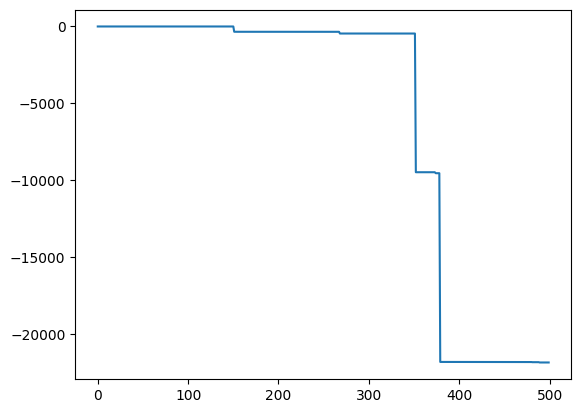

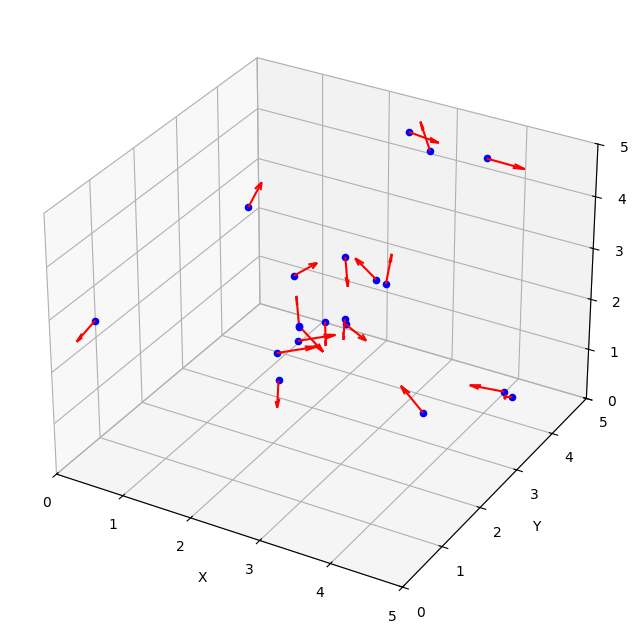

In [3]:
import matplotlib.pyplot as plt
s = simulation(N=20,L=5,T=1.0,steps=500, seed = 2)
plt.plot(s.energies)
s.grid.plot_3d_system()